In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from dython.nominal import associations
from wordcloud import WordCloud

In [63]:
df= pd.read_csv('spotifyData.csv', encoding='ISO-8859-1')
df = df.drop(['X'], axis=1) #removed column of indexes 
df = df.rename(columns={'artist':'artist name','bpm':'beats per minute',
                    'top.genre':'genre','nrgy':'energy','dnce':'danceability', 'dB':'loudness dB',
                    'spch':'speechiness','live':'liveness','val':'valence','dur':'duration','acous':'acousticness',
                    'pop':'popularity', 'emo' : 'bad feeling', 'ins': 'instrumentalness'})
df.head()

,title,artist name,genre,year,beats per minute,energy,danceability,loudness dB,liveness,valence,duration,acousticness,speechiness,popularity,bad feeling,instrumentalness
0,"Hey, Soul Sister",Train,neo mellow,2010,97.0,89.0,67.0,NaN,8.0,80.0,217.0,19.0,4.0,83.0,16.920,92.16
1,Love The Way You Lie,Eminem,detroit hip hop,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82.0,30.456,73.92
2,TiK ToK,Kesha,dance pop,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80.0,24.534,82.56
3,Bad Romance,Lady Gaga,dance pop,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,NaN,24.534,92.16
4,Just the Way You Are,Bruno Mars,pop,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78.0,48.222,92.16


# EDA 

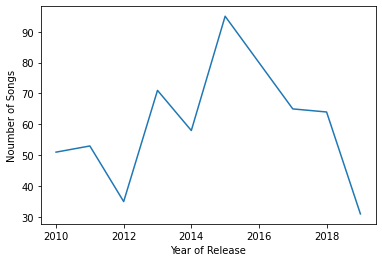

In [3]:
new_df = df[['year','title']].groupby('year').count()

sns.lineplot(x='year',y='title',data=new_df)

plt.ylabel('Noumber of Songs')
plt.xlabel('Year of Release')
plt.show()

Top of 10 genres from 2010 to 2019

In [4]:
def get_top_df(df, top = 10): #change 'top' value to see another top 

    top_lst = df.iloc[:]['genre'].value_counts().index[top:]
    df_other = df.replace(top_lst, 'Other')
    order_lst = list(df_other['genre'].value_counts().index)
    order_lst.remove('Other') #remove first 'Other'
    order_lst.append('Other') #append to the end 'Other'

    return df_other, order_lst

Text(0.5, 10.255999999999986, 'Number of songs')

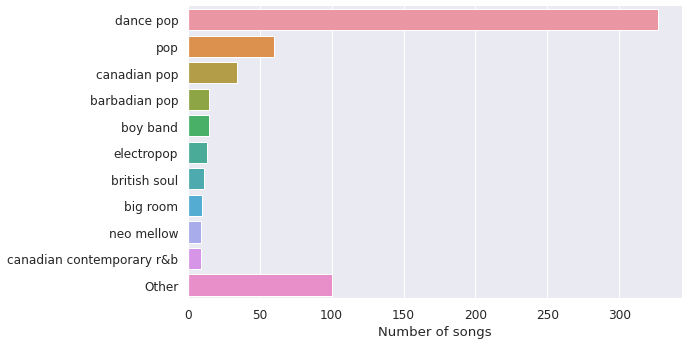

In [5]:
sns.set(font_scale=1.1)

df_top, order_lst = get_top_df(df)

sns.catplot(y = 'genre', data = df_top, kind = 'count', order= order_lst, aspect=2)
plt.ylabel('')
plt.xlabel('Number of songs')



Percentage normalization

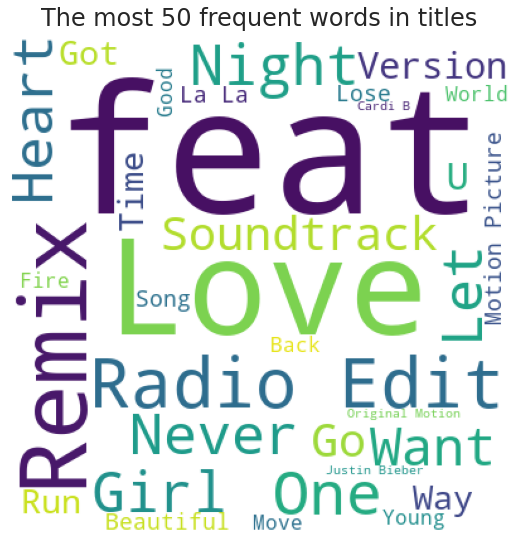

In [27]:
wordcloud = WordCloud(width = 400, height = 400, 
                background_color ='white', max_words = 50, colormap="viridis",
                min_font_size = 10).generate(" ".join(df['title']))

plt.figure(figsize=(7, 10))
plt.imshow(wordcloud)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(f"The most {50} frequent words in titles")
plt.show()

Top of 3 genres from 2010 to 2019

In [8]:
counted_genre = df.groupby(['genre', 'year']).size().unstack(fill_value=0)

In [9]:
df1 = pd.DataFrame()
for i in list(counted_genre.columns):
    df2 = counted_genre[i].sort_values(ascending=False)[:3]
    dict = {'Amount of songs': list(df2.values), 'genre': df2.index, 'year':i}
    tmp = pd.DataFrame(dict)
    df1 = df1.append(tmp, ignore_index=True)

Text(0, 0.5, 'Amount of songs')

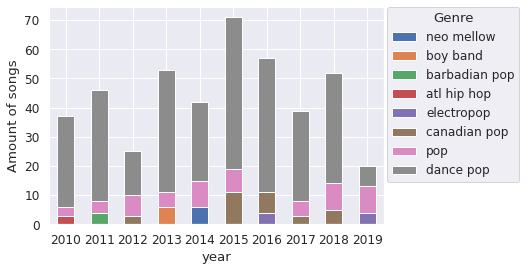

In [10]:
orderOfgenres = df1['genre'].value_counts().index[: : -1]
ax = df1.pivot(index='year', columns='genre', values='Amount of songs').iloc[:][orderOfgenres].plot(kind='bar', stacked=True, rot=0)

plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0, title = "Genre")
plt.ylabel('Amount of songs')

## Fix nan values

In [136]:
for i in range(3, 14): # Nan values are changed to a mean value that depends from genre name #until 'pop' columns 
    df_nan = df[df.iloc[:, i].isna()]
    df_nan = df_nan.loc[:, ['genre']]
    
    for j in range(len(df_nan)):
        artist_genre = df_nan.iloc[j].values
        df_artist_genre = df[df.loc[:, ['genre']].isin(artist_genre).all(axis=1)]
        meadian = df_artist_genre.iloc[:, i].dropna().median() # Why is here not mean? Beacuase I have ourliers in the dataset and also distribution is not simmetrical   
        index = df_artist_genre[df_artist_genre.iloc[:, i].isna()].index
        df.iloc[index, i] = meadian #

In [148]:
df.isnull().any()

title               False
artist name         False
genre               False
year                False
beats per minute     True
energy              False
danceability        False
loudness dB         False
liveness            False
valence             False
duration            False
acousticness        False
speechiness         False
popularity          False
bad feeling         False
instrumentalness    False
dtype: bool

In [149]:
df[df['beats per minute'].isnull()]

,title,artist name,genre,year,beats per minute,energy,danceability,loudness dB,liveness,valence,duration,acousticness,speechiness,popularity,bad feeling,instrumentalness
273,Take Me To Church,Hozier,irish singer-songwriter,2015,NaN,66.0,57.0,-5.0,12.0,44.0,242.0,63.0,5.0,81.0,47.376,91.2


In [150]:
df.iloc[273, 4] = 129 # found by the internet

### Correlation Heatmap

Calculate the correlation/strength-of-association of features in data-set with both categorical and continuous features using:

* Pearson's R for continuous-continuous cases
* Correlation Ratio for categorical-continuous cases
* Cramer's V or Theil's U for categorical-categorical cases

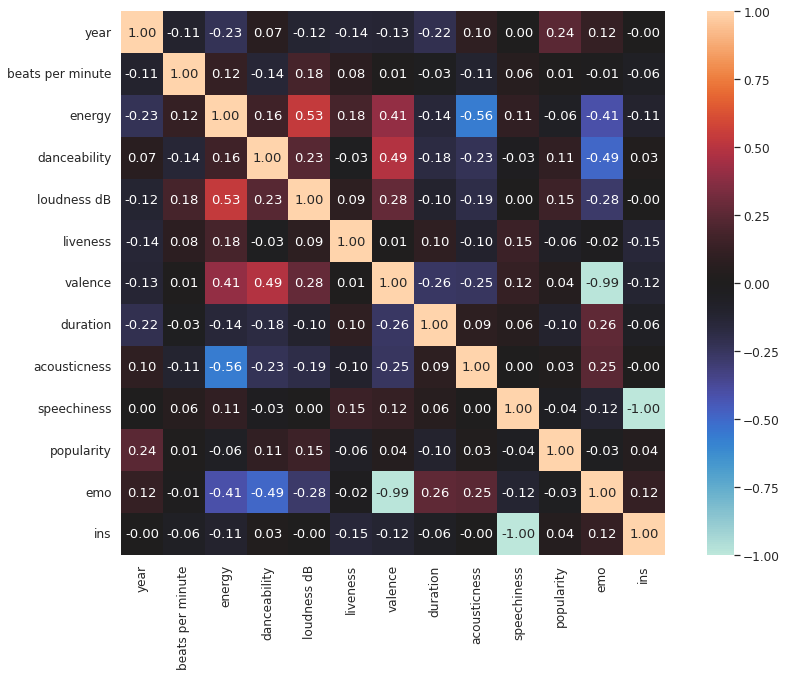

In [14]:
complete_correlation= associations(df.iloc[:, 3:], figsize=(15,10), clustering = False)

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,603.0,2014.592040,2.607057,2010.000,2013.000,2015.000,2017.00,2019.0
beats per minute,603.0,118.502488,24.652224,0.000,100.000,120.000,129.00,206.0
energy,603.0,70.470978,16.292093,0.000,61.000,74.000,82.00,98.0
danceability,603.0,64.515755,13.170653,0.000,57.000,66.000,73.00,97.0
loudness dB,603.0,-5.592040,2.798208,-60.000,-6.000,-5.000,-4.00,-2.0
liveness,603.0,17.711443,12.913190,0.000,9.000,12.000,24.00,74.0
valence,603.0,51.984245,22.213929,0.000,35.000,52.000,68.00,98.0
duration,603.0,224.718076,34.105954,134.000,202.000,221.000,239.50,424.0
acousticness,603.0,14.313433,20.768210,0.000,2.000,6.000,17.00,99.0
speechiness,603.0,8.351575,7.483921,0.000,4.000,5.000,9.00,48.0


In [57]:
order = df['genre'].value_counts()[df['genre'].value_counts().values > 10].index # get sorted genres with more than 10 songs 

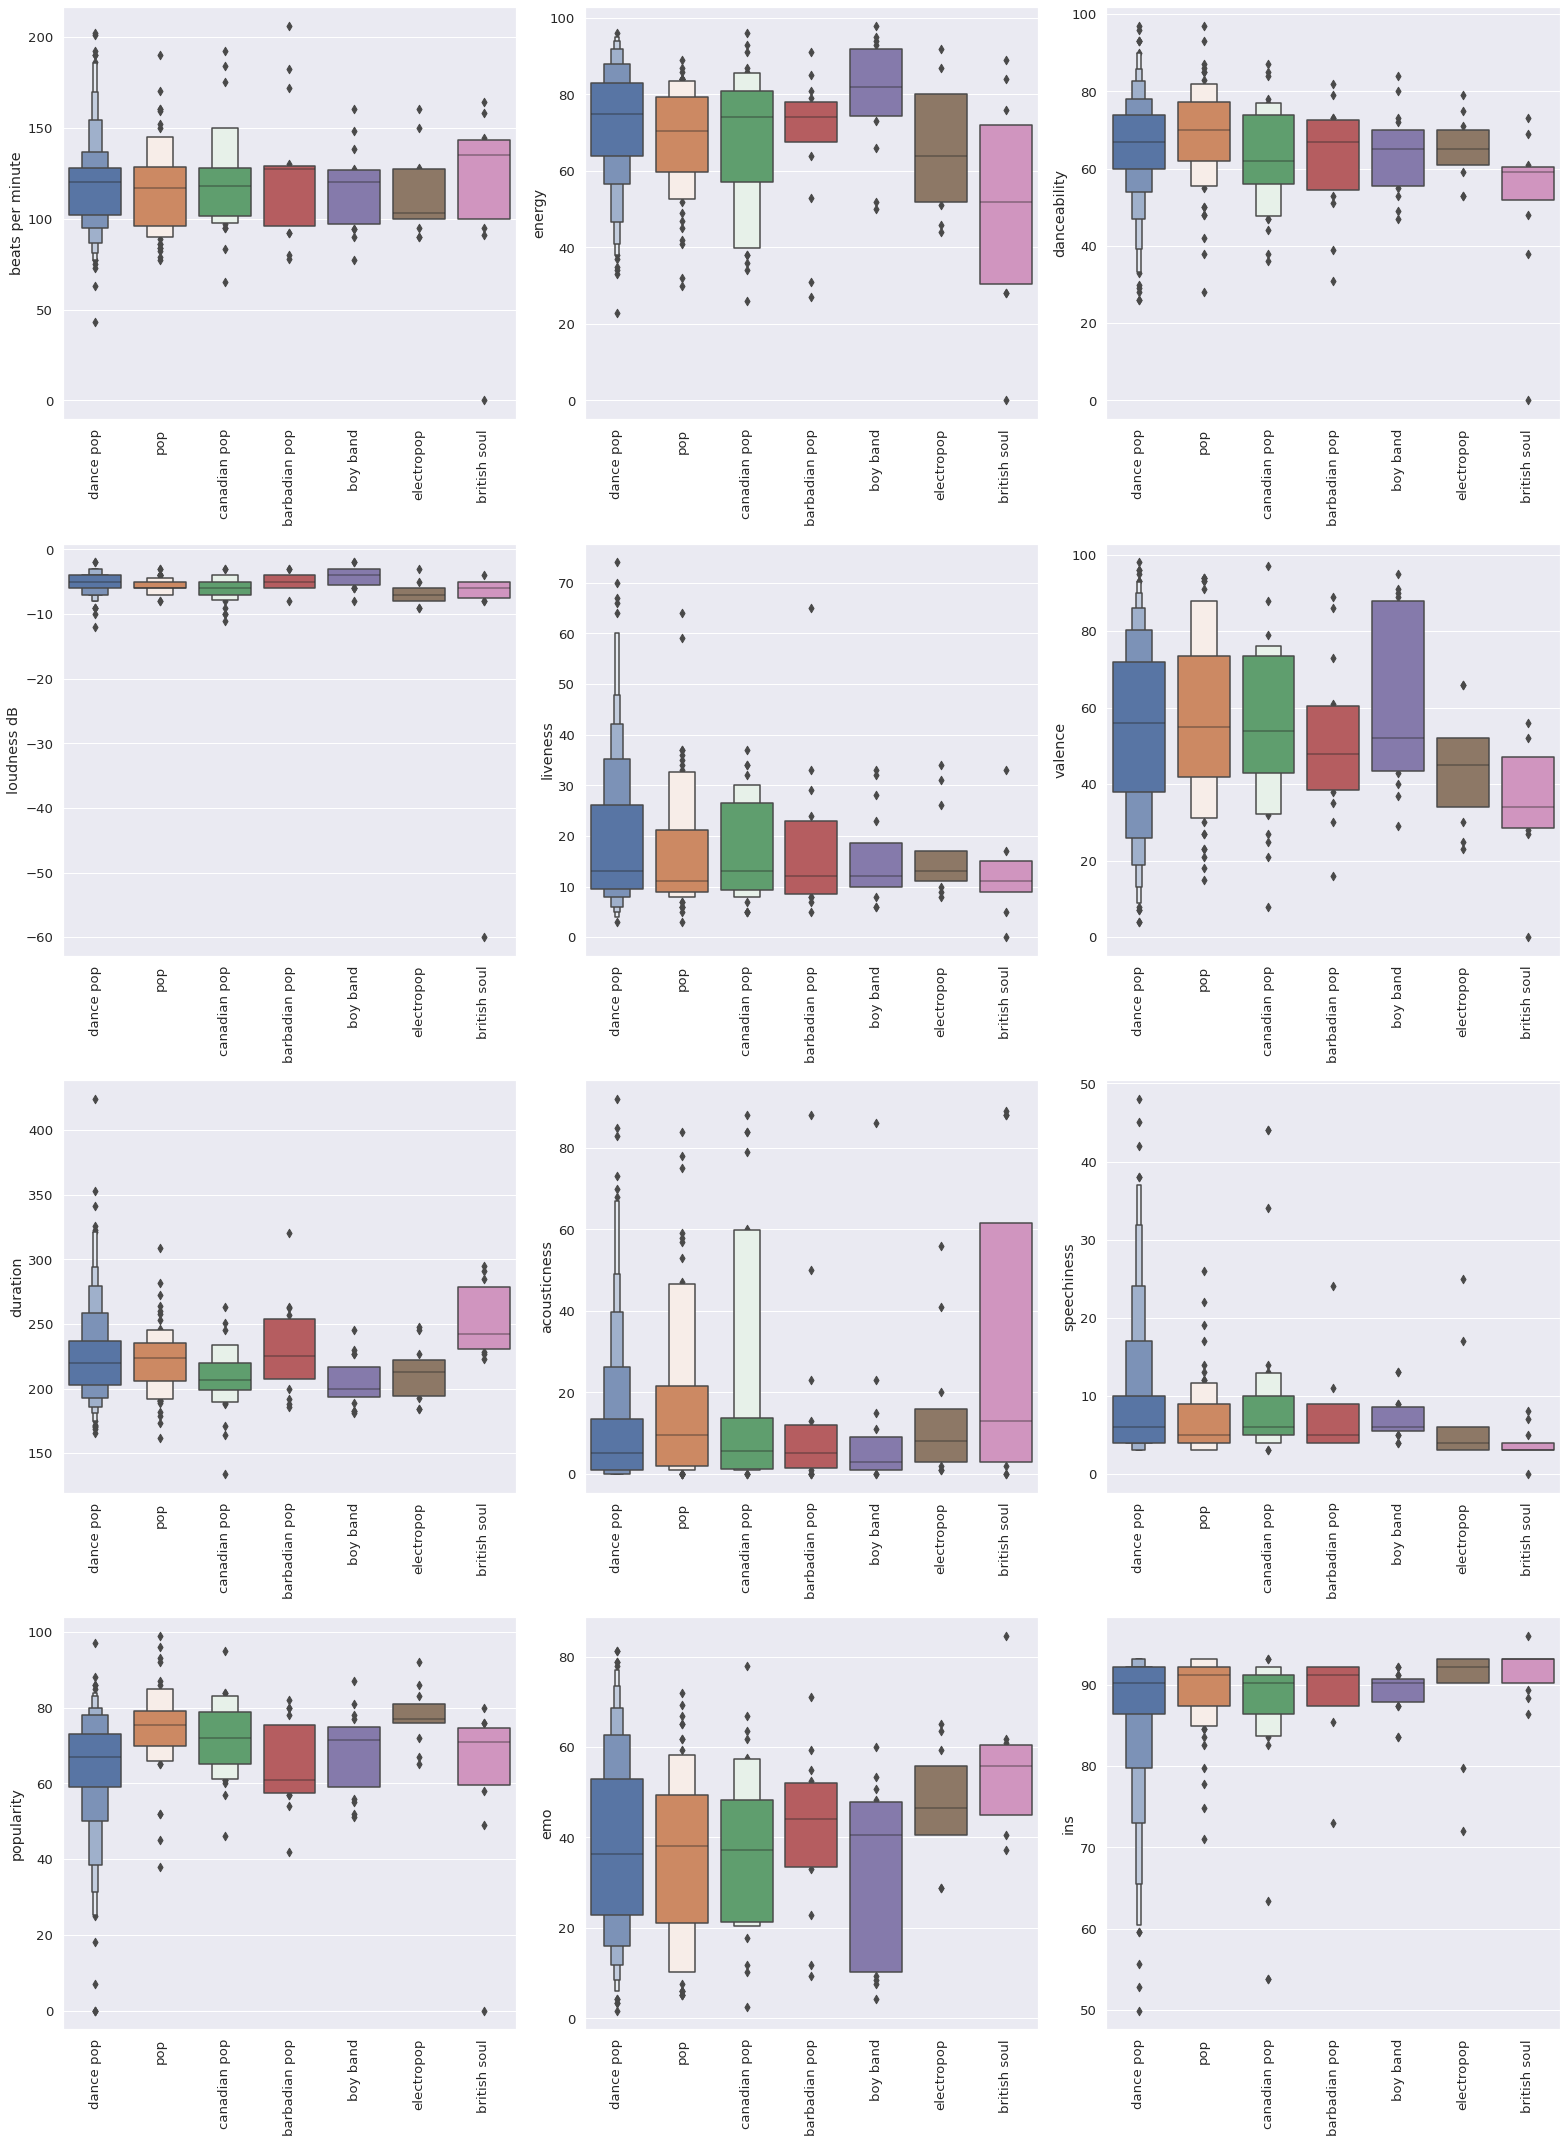

In [58]:
numerical_cols = df.drop('year', axis= 1).select_dtypes('number').columns.to_list()

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(22,30))
axs = np.ravel(axs)

for i, col in enumerate(numerical_cols):
    plt.sca(axs[i])
    #sns.catplot(y=col, x="top.genre", kind="boxen", data=df, order = order)
    sns.boxenplot(data=df, x='genre', y= col, order = order)
    plt.xlabel("")
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

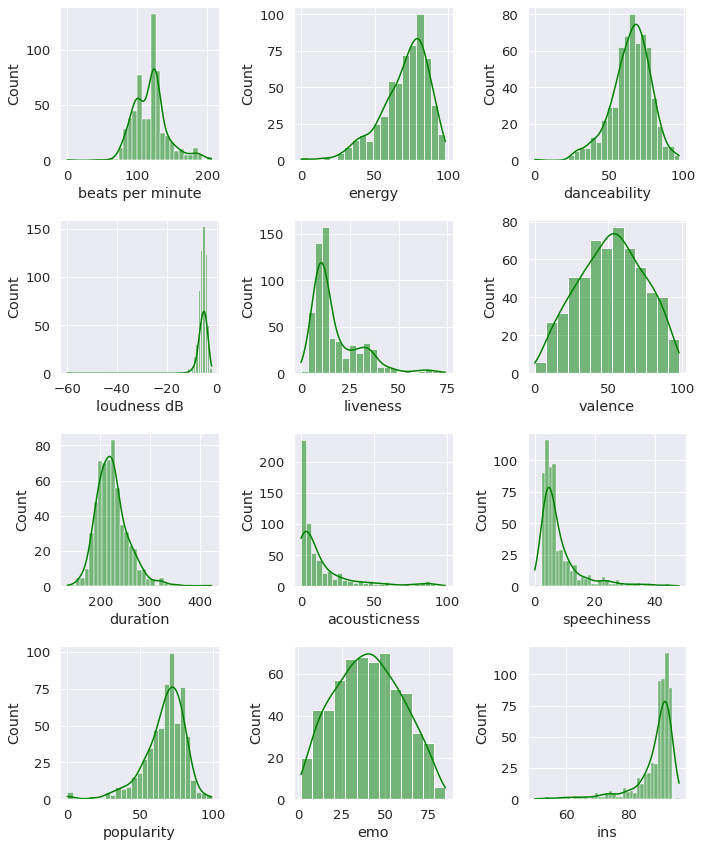

In [59]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10,12))
axs = np.ravel(axs)

for i, col in enumerate(numerical_cols):
    plt.sca(axs[i])
    sns.histplot(data=df, x=col, kde=True, color='green')

plt.tight_layout()
plt.show()

* dnce, val, dur, emo, pop have an appoximately normal distribution.

* nrgy, dB, ins features are right Skewed

* live, acous, spch features are Left Skewed

#### Number of songs for each year

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,603.0,2014.592040,2.607057,2010.000,2013.000,2015.000,2017.00,2019.0
beats per minute,603.0,118.502488,24.652224,0.000,100.000,120.000,129.00,206.0
energy,603.0,70.470978,16.292093,0.000,61.000,74.000,82.00,98.0
danceability,603.0,64.515755,13.170653,0.000,57.000,66.000,73.00,97.0
loudness dB,603.0,-5.592040,2.798208,-60.000,-6.000,-5.000,-4.00,-2.0
liveness,603.0,17.711443,12.913190,0.000,9.000,12.000,24.00,74.0
valence,603.0,51.984245,22.213929,0.000,35.000,52.000,68.00,98.0
duration,603.0,224.718076,34.105954,134.000,202.000,221.000,239.50,424.0
acousticness,603.0,14.313433,20.768210,0.000,2.000,6.000,17.00,99.0
speechiness,603.0,8.351575,7.483921,0.000,4.000,5.000,9.00,48.0


In [199]:
df_tmp = df.copy()

In [230]:
def min_max_scaling(series):
    return ((series - series.min())/(series.max()-series.min()))

In [236]:
columns = df.columns[4:]
columns = df_tmp.groupby("year")[columns].median().loc[2010].sort_values(ascending = False).index # sort columns by meadian value of 2010 year

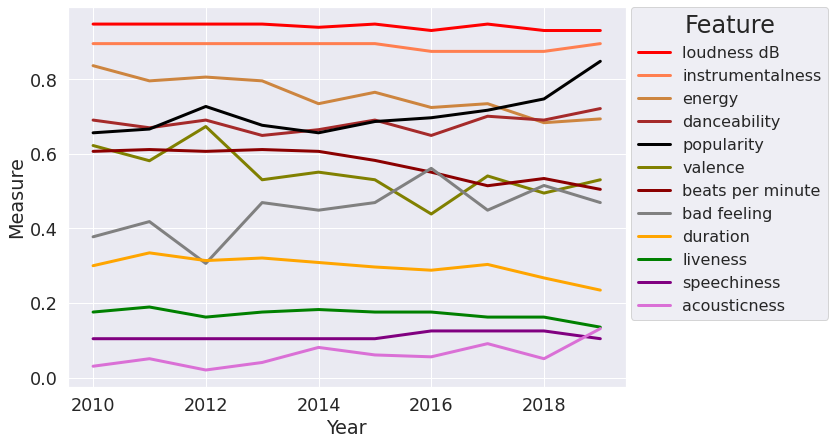

In [237]:
fig,ax = plt.subplots(figsize=(10, 7))

sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 3})

i = 0 
colors = ['red', 'coral', 'peru', 'brown', 'black', 'olive', 'darkred', 'gray', 'orange', 'green', 'purple', 'orchid']

for col in columns:
    df_tmp[col] = min_max_scaling(df[col].values) 
    x = df_tmp.groupby("year")[col].median()
    ax= sns.lineplot(x=x.index,y=x,label=col, color = colors[i])
    i += 1

ax.set_ylabel('Measure')
ax.set_xlabel('Year')
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0, title = "Feature", fontsize = 16)
sns.set(font_scale=1.6)

In general loudness dB, instrumentalness and speachcness features do not change much, songs are getting slightly instrumentalness. Songs are getting less energy, more danceable and popular, much less positive and more depressing, way shorter, less lively,  and  way more increasing. 

Lines of valence and bad feeling features are fully symmetric that means they have correlation, also speachness and instrumentalness (it is showed in correalatation heatmap).




## Predictions and Models 

In [ ]:
df = df.drop(['title'], axis = 1)

In [ ]:
from sklearn.preprocessing import LabelEncoder

artist_le= LabelEncoder()
artist_labels = artist_le.fit_transform(df['artist'])

top_genre = LabelEncoder()
label_genres = artist_le.fit_transform(df['top.genre'])

In [ ]:
df1 =df.copy()
df1['artist'] = artist_labels
df1['top.genre'] = label_genres

In [ ]:
X = df1.drop('top.genre', axis = 1)
y = df1['top.genre']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Spotify API

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import requests
import json

CLIENT_ID = "8e0273854b3b41d5b0e5d57709dacee8"
CLIENT_SECRET = "a222499edd0b4a9d97d65c6a0698b244"

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
cid = '8e0273854b3b41d5b0e5d57709dacee8'
secret = 'a222499edd0b4a9d97d65c6a0698b244'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [ ]:
artist_name = []
track_name = []
popularity = []
track_id = []
genres = []
for i in range(0,10,50):
    track_results = sp.search(q='year:2017', type='track', limit=50,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])

        artist_uri = t['album']['artists'][0]['uri']
        artist_info = sp.artist(artist_uri)
        artist = sp.artist(t["artists"][0]["external_urls"]["spotify"])

        try:
            genres.append(artist["genres"][0])
        except:
            genres.append(np.NaN)
        

        
        

In [ ]:
artist_uri = t['album']['artists'][0]['uri']
artist_info = sp.artist(artist_uri)
artist = sp.artist(t["artists"][0]["external_urls"]["spotify"])
artist["genres"][0]

In [ ]:
dict = {'title': track_name, 'artist': artist_name, 'top.genre': genres, 'year':2018}
pd.DataFrame(dict)